In [5]:
import pandas as pd
patch = pd.read_csv("patch.csv")
patch.head()

,val_rmse_mean,val_rmse_std,val_mae_mean,val_r2_mean,train_rmse_mean,train_mae_mean,train_r2_mean,n_folds,n_samples,model,scheme,level,atom_index,note
0,0.188953,0.053726,0.168094,-3.838650,0.1892,0.167383,-3.558292,5,510,FlaxMLP,ADCH,hf,0,NaN
1,0.035877,0.005584,0.013107,0.841620,NaN,NaN,NaN,5,510,KNN,ADCH,hf,0,NaN
2,0.065052,0.003709,0.056129,0.481692,NaN,NaN,NaN,5,510,SVR,ADCH,hf,0,NaN
3,0.008250,0.004082,0.004830,0.989646,NaN,NaN,NaN,5,510,DecisionTree,ADCH,hf,0,NaN
4,0.005610,0.002466,0.002709,0.995190,NaN,NaN,NaN,5,510,RandomForest,ADCH,hf,0,NaN


In [22]:
charges_long = pd.read_csv("df_charges_long.csv")
charges_long.head()

,r1,r2,ang,level,atom_index,atom,scheme,value
0,1.0,1.0,120.0,hf,0,C,Hirshfeld,0.424593
1,1.0,1.0,120.0,hf,1,O,Hirshfeld,-0.212303
2,1.0,1.0,120.0,hf,2,O,Hirshfeld,-0.212289
3,1.0,1.0,120.0,hf,0,C,VDD,0.430338
4,1.0,1.0,120.0,hf,1,O,VDD,-0.217065


In [24]:
charges_long.groupby(["scheme", ]).describe()["value"]

,count,mean,std,min,25%,50%,75%,max
scheme,,,,,,,,
ADCH,3060.0,-8.823541e-13,0.496034,-0.504493,-0.408955,-0.243451,0.630342,0.783232
Becke,3060.0,-3.594765e-13,0.508179,-0.566010,-0.416316,-0.264895,0.652800,0.866921
CHELPG,3060.0,-3.267982e-13,0.630981,-0.575979,-0.517867,-0.354911,0.791134,1.092346
CM5,3060.0,-3.267954e-14,0.368915,-0.383262,-0.284738,-0.192725,0.506306,0.550493
Hirshfeld,3060.0,-9.150327e-13,0.300153,-0.363132,-0.231989,-0.129775,0.407424,0.500805
MBIS,3060.0,1.233581e-18,0.854387,-0.734478,-0.671170,-0.526293,1.101061,1.468953
MBIS_raw,3060.0,4.491212e-06,0.854386,-0.734467,-0.671173,-0.526284,1.101069,1.468958
MK,3060.0,-3.921578e-13,0.597194,-0.561811,-0.496355,-0.322669,0.741604,1.060563
VDD,3060.0,-1.568628e-12,0.330490,-0.405693,-0.262468,-0.134326,0.438735,0.574003


In [25]:
(patch[patch["scheme"]=="MBIS_raw"]).groupby(["scheme", "model", ]).describe()["val_rmse_mean"].sort_values("mean")

count      mean       std       min       25%  \
scheme   model                                                             
MBIS_raw GradientBoosting    6.0  0.006306  0.001930  0.003869  0.004774   
         RandomForest        6.0  0.007239  0.002307  0.004397  0.005511   
         KNN                 6.0  0.009039  0.003611  0.004628  0.007440   
         DecisionTree        6.0  0.011563  0.005121  0.007293  0.007743   
         SVR                 6.0  0.056105  0.005724  0.049100  0.052007   
         FlaxMLP             6.0  0.211497  0.072655  0.125282  0.152770   

                                50%       75%       max  
scheme   model                                           
MBIS_raw GradientBoosting  0.006524  0.007603  0.008767  
         RandomForest      0.007151  0.009048  0.010089  
         KNN               0.008598  0.009587  0.015438  
         DecisionTree      0.009299  0.015965  0.018079  
         SVR               0.056001  0.059159  0.064641  
         FlaxMLP           0.224065  0.243462  0.316639

ValueError: The length of facecolors must match the number of triangles

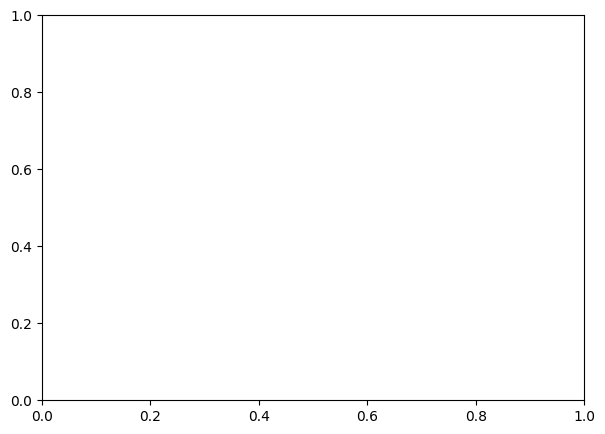

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

# =============================================================
# 1. Example input: atomic centers, radii, charges
# =============================================================
atoms = np.array([
    [0.000, 0.000, 0.000, 1.70, -0.2],   # C
    [1.09,  0.00,  0.00, 1.20,  +0.05],  # H
    [-0.36, 1.03,  0.00, 1.20,  +0.05],
    [-0.36,-0.51,  0.89, 1.20,  +0.05],
    [-0.36,-0.51, -0.89, 1.20,  +0.05],
], dtype=float)

# =============================================================
# 2. Create a "molecular surface" mesh by sampling each sphere
# =============================================================
def sphere_mesh(center, radius, n_theta=40, n_phi=80):
    """Generate a sphere mesh centered at center with given radius."""
    theta = np.linspace(0, np.pi, n_theta)
    phi = np.linspace(0, 2*np.pi, n_phi)
    theta, phi = np.meshgrid(theta, phi, indexing='ij')
    x = center[0] + radius * np.sin(theta) * np.cos(phi)
    y = center[1] + radius * np.sin(theta) * np.sin(phi)
    z = center[2] + radius * np.cos(theta)
    return np.stack([x, y, z], axis=-1).reshape(-1, 3), theta.reshape(-1), phi.reshape(-1)

# concatenate all atoms’ spherical patches
verts_list, theta_list, phi_list = [], [], []
for atom in atoms:
    v, th, ph = sphere_mesh(atom[:3], atom[3])
    verts_list.append(v)
    theta_list.append(th)
    phi_list.append(ph)

verts = np.concatenate(verts_list)
theta = np.concatenate(theta_list)
phi = np.concatenate(phi_list)

# connect to a triangulation in UV space
u = phi / (2*np.pi)
v = theta / np.pi
tri = mtri.Triangulation(u, v)

# =============================================================
# 3. Compute ESP at each vertex from point charges
# =============================================================
charges = atoms[:,4]
centers = atoms[:,:3]

def esp_at_points(P, centers, charges):
    diff = P[:,None,:] - centers[None,:,:]
    r = np.linalg.norm(diff, axis=-1)
    inv_r = 1.0 / np.maximum(r, 1e-6)
    phi = (charges[None,:] * inv_r).sum(axis=1)
    return phi

phi_val = esp_at_points(verts, centers, charges)
phi_val = np.clip(phi_val, np.percentile(phi_val, 2), np.percentile(phi_val, 98))

# =============================================================
# 4. Flatten and plot as 2D shaded mesh
# =============================================================
plt.figure(figsize=(7,5))
plt.tripcolor(tri, facecolors=phi_val, shading='gouraud', cmap='coolwarm')
plt.xlabel("u (longitude)"); plt.ylabel("v (latitude)")
plt.title("Flattened molecular surface shaded by ESP")
plt.colorbar(label="ESP (arb. units)")
plt.tight_layout()
plt.show()


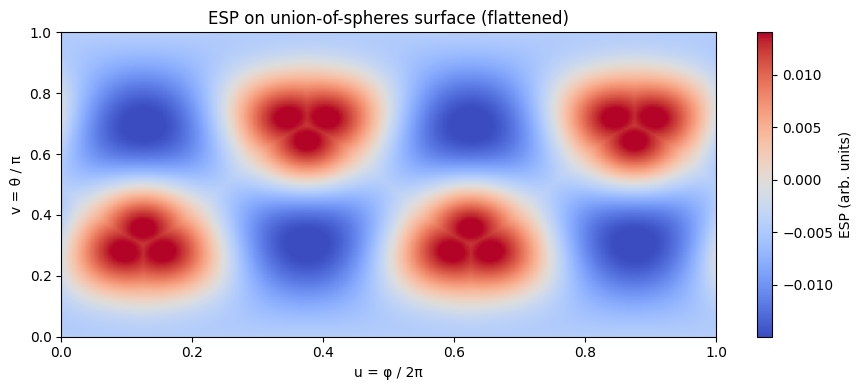

In [28]:
# esp_flatmap_jax.py
# Requirements: jax, ase, matplotlib
# All math is done in JAX; matplotlib is only used at the end for imshow.

import jax
import jax.numpy as jnp
from jax import jit, vmap, lax
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Helpers: load geometry/radii from ASE
# ----------------------------
def ase_to_arrays(ase_atoms, probe_radius=1.40, radii_source="vdw"):
    """
    Returns (centers [N,3], radii [N], charges [N]).
    - radii_source: "vdw" or "covalent"
    - charges: uses ase_atoms.get_initial_charges() if present, else zeros.
    """
    from ase.data import vdw_radii, covalent_radii

    pos = np.asarray(ase_atoms.get_positions(), dtype=np.float64)  # Å
    Z = np.asarray(ase_atoms.get_atomic_numbers(), dtype=int)

    if radii_source == "vdw":
        r = np.array([vdw_radii[z] for z in Z], dtype=np.float64)
    elif radii_source == "covalent":
        r = np.array([covalent_radii[z] for z in Z], dtype=np.float64)
    else:
        raise ValueError("radii_source must be 'vdw' or 'covalent'")

    r = r + probe_radius  # solvent-accessible style
    try:
        q = np.asarray(ase_atoms.get_initial_charges(), dtype=np.float64)
    except Exception:
        q = np.zeros(len(Z), dtype=np.float64)

    return pos, r, q

# ----------------------------
# Geometry on the sphere
# ----------------------------
def sphere_uv_grid(n_theta=256, n_phi=512):
    """
    Equirectangular UV sampling:
      theta in [0, pi] (latitude), phi in [0, 2pi) (longitude)
    Returns:
      theta [H,W], phi [H,W], and unit directions [H,W,3].
    """
    theta = jnp.linspace(0.0, jnp.pi, n_theta)
    phi   = jnp.linspace(0.0, 2.0*jnp.pi, n_phi, endpoint=False)
    TH, PH = jnp.meshgrid(theta, phi, indexing="ij")
    # unit directions for each (theta,phi)
    sinT = jnp.sin(TH)
    dirs = jnp.stack([sinT*jnp.cos(PH), sinT*jnp.sin(PH), jnp.cos(TH)], axis=-1)  # [H,W,3]
    return TH, PH, dirs

# ----------------------------
# Ray/sphere intersections for union-of-spheres surface
# ----------------------------
@jit
def first_surface_hit_t(origin, direction, centers, radii):
    """
    For ray p(t) = origin + t*direction (t >= 0), find first intersection with the
    union of spheres centered at 'centers' with radii 'radii'.

    If origin is inside any sphere, return the smallest positive EXIT (t_exit) among those.
    Else return the smallest nonnegative ENTRY (t_enter) among spheres the ray hits.
    If no hit, returns jnp.nan.
    """
    # Vector from each sphere center to origin
    vec = origin - centers  # [N,3]
    b = jnp.dot(direction, vec.T)  # [N] (since direction is [3], vec is [N,3], this broadcasts)
    c = jnp.einsum('ij,ij->i', vec, vec) - radii**2  # [N]
    disc = b**2 - c  # [N]

    # Inside-sphere mask: c < 0  (||origin - ci|| < ri)
    inside = c < 0.0

    # Valid discriminant mask
    valid = disc >= 0.0
    sqrt_disc = jnp.sqrt(jnp.maximum(disc, 0.0))

    # Entry/exit parameters
    t_enter = -b - sqrt_disc
    t_exit  = -b + sqrt_disc

    # Case A: origin inside some spheres -> choose smallest positive exit among those
    t_exit_inside = jnp.where(inside, t_exit, jnp.inf)
    tA = jnp.min(t_exit_inside)

    # Case B: origin outside all spheres -> choose smallest nonnegative entry among valid hits
    t_enter_valid = jnp.where(valid, t_enter, jnp.inf)
    t_enter_valid = jnp.where(t_enter_valid >= 0.0, t_enter_valid, jnp.inf)
    tB = jnp.min(t_enter_valid)

    # Pick A if we are inside any sphere, else B. If result is inf -> no hit.
    any_inside = jnp.any(inside)
    t = jnp.where(any_inside, tA, tB)
    t = jnp.where(jnp.isfinite(t), t, jnp.nan)
    return t

# Vectorize over a batch of directions
first_surface_hit_t_batch = jit(vmap(first_surface_hit_t, in_axes=(None, 0, None, None)))

# ----------------------------
# ESP on the surface
# ----------------------------
@jit
def esp_at_points(points, centers, charges, eps=1e-8):
    # points: [M,3]; centers: [N,3]; returns [M]
    diff = points[:, None, :] - centers[None, :, :]
    r = jnp.linalg.norm(diff, axis=-1)
    inv_r = 1.0 / jnp.maximum(r, eps)
    return jnp.sum(charges[None, :] * inv_r, axis=1)

# ----------------------------
# End-to-end: UV map of ESP
# ----------------------------
def esp_flatmap(centers_np, radii_np, charges_np, origin_np=None, n_theta=256, n_phi=512):
    """
    Returns (esp_map [H,W], mask [H,W], theta [H,W], phi [H,W]).
    mask==True where a surface was hit; False where the ray missed all spheres.
    """
    centers = jnp.asarray(centers_np, dtype=jnp.float32)
    radii   = jnp.asarray(radii_np,   dtype=jnp.float32)
    charges = jnp.asarray(charges_np, dtype=jnp.float32)

    # Choose origin: default = geometric centroid
    if origin_np is None:
        origin_np = np.mean(centers_np, axis=0)
    origin = jnp.asarray(origin_np, dtype=jnp.float32)

    TH, PH, DIR = sphere_uv_grid(n_theta=n_theta, n_phi=n_phi)  # [H,W,3]
    H, W = TH.shape

    # Flatten directions to [M,3]
    DIR_flat = DIR.reshape(-1, 3)

    # Compute first-hit t for all directions
    t_flat = first_surface_hit_t_batch(origin, DIR_flat, centers, radii)  # [M]

    # Valid hits
    hit_mask_flat = jnp.isfinite(t_flat)
    P_flat = origin[None, :] + t_flat[:, None] * DIR_flat  # [M,3]; NaNs propagate on miss

    # ESP at hit points; fill misses with 0
    esp_flat = esp_at_points(P_flat, centers, charges)
    esp_flat = jnp.where(hit_mask_flat, esp_flat, 0.0)

    # Reshape to [H,W]
    esp_map = esp_flat.reshape(H, W)
    mask = hit_mask_flat.reshape(H, W)
    return esp_map, mask, TH, PH

# ----------------------------
# Demo / usage
# ----------------------------
if __name__ == "__main__":
    from ase.build import molecule

    # Build a methane and assign simple charges
    ase_atoms = molecule("CH4")
    centers_np, radii_np, charges_np = ase_to_arrays(
        ase_atoms, probe_radius=1.40, radii_source="vdw"
    )

    # Toy partial charges: -0.2 on C, +0.05 on each H
    charges_np[:] = 0.0
    # crude assignment by element number
    Z = np.array(ase_atoms.get_atomic_numbers())
    charges_np[Z == 6] = -0.2
    charges_np[Z == 1] = +0.05

    # Resolution (increase for quality; cost grows ~ n_theta*n_phi)
    H, W = 400, 800
    esp_map, mask, TH, PH = esp_flatmap(
        centers_np, radii_np, charges_np, origin_np=None, n_theta=H, n_phi=W
    )

    # Optional: clip for nicer contrast
    esp_vals = np.asarray(esp_map)
    valid_vals = esp_vals[np.asarray(mask)]
    if valid_vals.size > 0:
        lo, hi = np.percentile(valid_vals, [2, 98])
        esp_disp = np.clip(esp_vals, lo, hi)
    else:
        esp_disp = esp_vals

    # Show with imshow (mpl ONLY here)
    plt.figure(figsize=(9, 4))
    plt.imshow(
        esp_disp,
        origin="lower",
        aspect="auto",
        extent=[0.0, 1.0, 0.0, 1.0],  # u in [0,1], v in [0,1]
        interpolation="nearest",
        cmap="coolwarm",
    )
    plt.xlabel("u = φ / 2π")
    plt.ylabel("v = θ / π")
    plt.title("ESP on union-of-spheres surface (flattened)")
    plt.colorbar(label="ESP (arb. units)")
    # overlay a hatch for rays that missed the surface (rare if origin inside)
    miss = ~np.asarray(mask)
    if miss.any():
        # simple overlay: dim out misses
        alpha = np.ones_like(esp_disp) * 0.25
        alpha[miss] = 0.6
    plt.tight_layout()
    plt.show()


/scratch/boitti0000/slurm-job.61203577/ipykernel_2188876/884775093.py:268: RuntimeWarning: invalid value encountered in divide
  out = np.where(cnt>0, acc/cnt, np.nan)
/scratch/boitti0000/slurm-job.61203577/ipykernel_2188876/884775093.py:294: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


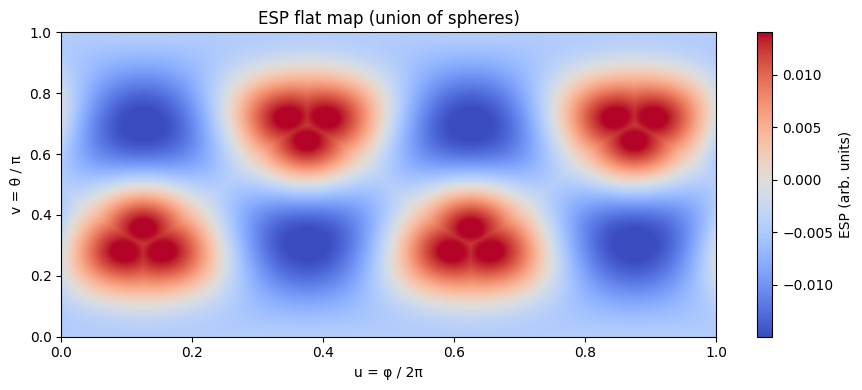

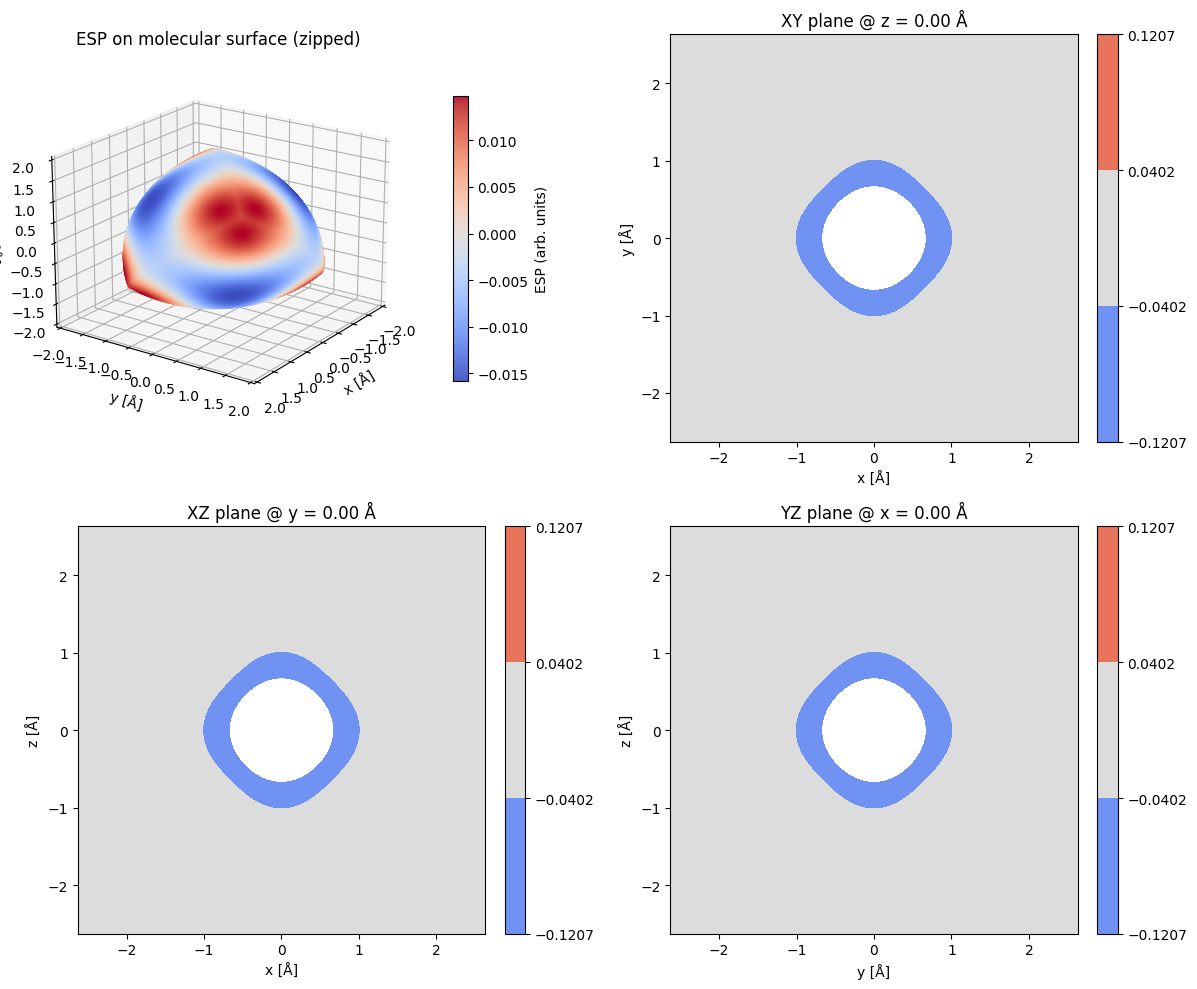

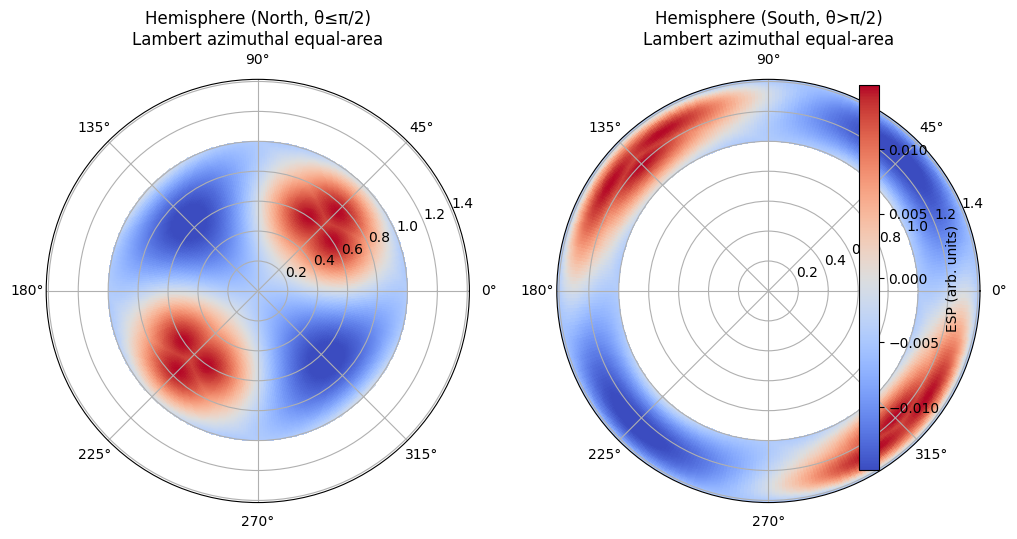

In [31]:
# esp_views_jax.py
# JAX math + ASE geometry; MPL only for plotting (imshow/contour/pcolormesh/scatter).

import jax
import jax.numpy as jnp
from jax import jit, vmap
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from ase.build import molecule
from ase.data import vdw_radii

# ----------------------------
# ASE helpers
# ----------------------------
def ase_to_arrays(ase_atoms, probe_radius=1.40, radii_source="vdw"):
    Z = np.asarray(ase_atoms.get_atomic_numbers(), dtype=int)
    pos = np.asarray(ase_atoms.get_positions(), dtype=np.float64)
    if radii_source == "vdw":
        r = np.array([vdw_radii[z] for z in Z], dtype=np.float64)
    else:
        raise ValueError("Only 'vdw' implemented in this snippet")
    r = r + probe_radius
    try:
        q = np.asarray(ase_atoms.get_initial_charges(), dtype=np.float64)
    except Exception:
        q = np.zeros(len(Z), dtype=np.float64)
    return pos, r, q, Z

# ----------------------------
# Sphere parameterization + ray casting
# ----------------------------
def sphere_uv_grid(n_theta=256, n_phi=512):
    theta = jnp.linspace(0.0, jnp.pi, n_theta)
    phi   = jnp.linspace(0.0, 2.0*jnp.pi, n_phi, endpoint=False)
    TH, PH = jnp.meshgrid(theta, phi, indexing="ij")
    sinT = jnp.sin(TH)
    dirs = jnp.stack([sinT*jnp.cos(PH), sinT*jnp.sin(PH), jnp.cos(TH)], axis=-1)  # [H,W,3]
    return TH, PH, dirs

@jit
def first_surface_hit_t(origin, direction, centers, radii):
    # Ray p(t)=origin + t*direction
    vec = origin - centers           # [N,3]
    b = jnp.dot(direction, vec.T)    # [N]
    c = jnp.einsum('ij,ij->i', vec, vec) - radii**2
    disc = b**2 - c
    inside = c < 0.0
    valid = disc >= 0.0
    sqrt_disc = jnp.sqrt(jnp.maximum(disc, 0.0))
    t_enter = -b - sqrt_disc
    t_exit  = -b + sqrt_disc
    t_exit_inside = jnp.where(inside, t_exit, jnp.inf)
    t_inside = jnp.min(t_exit_inside)
    t_enter_valid = jnp.where(valid, t_enter, jnp.inf)
    t_enter_valid = jnp.where(t_enter_valid >= 0.0, t_enter_valid, jnp.inf)
    t_outside = jnp.min(t_enter_valid)
    any_inside = jnp.any(inside)
    t = jnp.where(any_inside, t_inside, t_outside)
    t = jnp.where(jnp.isfinite(t), t, jnp.nan)
    return t

first_surface_hit_t_batch = jit(vmap(first_surface_hit_t, in_axes=(None, 0, None, None)))

@jit
def esp_at_points(points, centers, charges, eps=1e-8):
    diff = points[:, None, :] - centers[None, :, :]
    r = jnp.linalg.norm(diff, axis=-1)
    inv_r = 1.0 / jnp.maximum(r, eps)
    return jnp.sum(charges[None, :] * inv_r, axis=1)

def esp_flatmap_and_points(centers_np, radii_np, charges_np, origin_np=None, n_theta=256, n_phi=512):
    centers = jnp.asarray(centers_np, dtype=jnp.float32)
    radii   = jnp.asarray(radii_np,   dtype=jnp.float32)
    charges = jnp.asarray(charges_np, dtype=jnp.float32)
    if origin_np is None:
        origin_np = np.mean(centers_np, axis=0)
    origin = jnp.asarray(origin_np, dtype=jnp.float32)

    TH, PH, DIR = sphere_uv_grid(n_theta=n_theta, n_phi=n_phi)  # [H,W,3]
    H, W = TH.shape
    DIR_flat = DIR.reshape(-1, 3)
    t_flat = first_surface_hit_t_batch(origin, DIR_flat, centers, radii)  # [M]
    hit_mask_flat = jnp.isfinite(t_flat)
    P_flat = origin[None, :] + t_flat[:, None] * DIR_flat                  # [M,3]
    esp_flat = esp_at_points(P_flat, centers, charges)
    esp_flat = jnp.where(hit_mask_flat, esp_flat, 0.0)
    return (np.asarray(esp_flat).reshape(H, W),
            np.asarray(hit_mask_flat).reshape(H, W),
            np.asarray(TH), np.asarray(PH),
            np.asarray(P_flat).reshape(H, W, 3))

# ----------------------------
# ESP on orthogonal planes (XY @ z0, YZ @ x0, XZ @ y0)
# ----------------------------
def esp_on_plane(centers_np, charges_np, plane='xy', fixed=0.0, span=None, res=300):
    centers = jnp.asarray(centers_np, dtype=jnp.float32)
    charges = jnp.asarray(charges_np, dtype=jnp.float32)

    if span is None:
        mins = centers_np.min(axis=0) - 2.0
        maxs = centers_np.max(axis=0) + 2.0
    else:
        mins, maxs = span

    if plane == 'xy':
        x = jnp.linspace(mins[0], maxs[0], res)
        y = jnp.linspace(mins[1], maxs[1], res)
        X, Y = jnp.meshgrid(x, y, indexing='xy')
        P = jnp.stack([X, Y, jnp.full_like(X, fixed)], axis=-1).reshape(-1, 3)
    elif plane == 'yz':
        y = jnp.linspace(mins[1], maxs[1], res)
        z = jnp.linspace(mins[2], maxs[2], res)
        Y, Z = jnp.meshgrid(y, z, indexing='xy')
        P = jnp.stack([jnp.full_like(Y, fixed), Y, Z], axis=-1).reshape(-1, 3)
    elif plane == 'xz':
        x = jnp.linspace(mins[0], maxs[0], res)
        z = jnp.linspace(mins[2], maxs[2], res)
        X, Z = jnp.meshgrid(x, z, indexing='xy')
        P = jnp.stack([X, jnp.full_like(X, fixed), Z], axis=-1).reshape(-1, 3)
    else:
        raise ValueError("plane must be 'xy', 'yz', or 'xz'")

    vals = esp_at_points(P, centers, charges)
    V = np.asarray(vals).reshape(res, res)
    return V, (mins, maxs)

# ----------------------------
# Polar hemispheres (Lambert azimuthal equal-area)
# ----------------------------
def hemispheres_polar(esp_map, mask, TH, PH):
    # Inputs are from esp_flatmap_and_points
    # North: theta in [0, pi/2]; South: theta in (pi/2, pi]
    theta = TH
    phi   = PH
    # Select indices
    north = theta <= (np.pi/2)
    south = ~north
    # Lambert azimuthal equal-area: r = sqrt(2) * sin(theta/2)
    r_all = np.sqrt(2.0) * np.sin(theta/2.0)
    rN, rS = r_all[north], r_all[south]
    phiN, phiS = phi[north], phi[south]
    valN = esp_map[north]
    valS = esp_map[south]
    maskN = mask[north]
    maskS = mask[south]
    return (rN, phiN, valN, maskN), (rS, phiS, valS, maskS)

# ----------------------------
# Demo + Plots
# ----------------------------
if __name__ == "__main__":
    # Example molecule: methane with simple charges
    atoms = molecule("CH4")
    Z = np.array(atoms.get_atomic_numbers())
    q = np.zeros(len(Z))
    q[Z == 6] = -0.2
    q[Z == 1] = +0.05
    atoms.set_initial_charges(q)

    centers_np, radii_np, charges_np, Z = ase_to_arrays(atoms, probe_radius=1.40, radii_source="vdw")

    # Build UV map + 3D surface points
    H, W = 400, 800
    esp_map, mask, TH, PH, P3 = esp_flatmap_and_points(centers_np, radii_np, charges_np,
                                                       origin_np=None, n_theta=H, n_phi=W)

    # Contrast for display
    if mask.any():
        vals = esp_map[mask]
        lo, hi = np.percentile(vals, [2, 98])
        esp_disp = np.clip(esp_map, lo, hi)
    else:
        esp_disp = esp_map

    # ---------------- 1) Flat map ----------------
    plt.figure(figsize=(9, 4))
    plt.imshow(esp_disp, origin="lower", aspect="auto", extent=[0, 1, 0, 1], cmap="coolwarm")
    plt.xlabel("u = φ / 2π"); plt.ylabel("v = θ / π")
    plt.title("ESP flat map (union of spheres)")
    plt.colorbar(label="ESP (arb. units)")
    plt.tight_layout()

    # ---------------- 2) 3D “zipped” + three orthogonal contour panels ----------------
    # Compute ESP on mid-planes through the molecular centroid
    centroid = centers_np.mean(axis=0)
    # Expand plotting window a bit
    mins = centers_np.min(axis=0) - 2.0
    maxs = centers_np.max(axis=0) + 2.0
    span = (mins, maxs)
    res_slice = 300

    V_xy, _ = esp_on_plane(centers_np, charges_np, plane='xy', fixed=centroid[2], span=span, res=res_slice)
    V_yz, _ = esp_on_plane(centers_np, charges_np, plane='yz', fixed=centroid[0], span=span, res=res_slice)
    V_xz, _ = esp_on_plane(centers_np, charges_np, plane='xz', fixed=centroid[1], span=span, res=res_slice)

    # Choose 4 wise contour levels: symmetric, robust
    all_vals = np.concatenate([V_xy.ravel(), V_yz.ravel(), V_xz.ravel()])
    L = np.percentile(np.abs(all_vals), 95)  # robust scale
    levels = np.array([-L, -L/3, L/3, L])

    # Build the figure: 2x2 — 3D + XY + YZ + XZ
    fig = plt.figure(figsize=(12, 10))
    ax3d = fig.add_subplot(221, projection='3d')

    # Downsample surface points for scatter density
    s = 2
    P = P3[::s, ::s, :].reshape(-1, 3)
    C = esp_map[::s, ::s].reshape(-1)
    M = mask[::s, ::s].reshape(-1)
    P = P[M]; C = C[M]

    sc = ax3d.scatter(P[:,0], P[:,1], P[:,2], c=C, s=3, alpha=0.9, cmap="coolwarm")
    ax3d.scatter(centers_np[:,0], centers_np[:,1], centers_np[:,2], s=60, c="k", alpha=0.6)
    cbar = plt.colorbar(sc, ax=ax3d, pad=0.1, shrink=0.7)
    cbar.set_label("ESP (arb. units)")
    ax3d.set_title("ESP on molecular surface (zipped)")
    ax3d.set_xlabel("x [Å]"); ax3d.set_ylabel("y [Å]"); ax3d.set_zlabel("z [Å]")
    ax3d.view_init(elev=20, azim=35)

    # Axes extents for contour panels
    X = np.linspace(mins[0], maxs[0], res_slice)
    Y = np.linspace(mins[1], maxs[1], res_slice)
    Z = np.linspace(mins[2], maxs[2], res_slice)

    # XY panel
    ax_xy = fig.add_subplot(222)
    cntr_xy = ax_xy.contourf(X, Y, V_xy, levels=levels, cmap="coolwarm")
    ax_xy.set_aspect('equal', 'box')
    ax_xy.set_title("XY plane @ z = {:.2f} Å".format(centroid[2]))
    ax_xy.set_xlabel("x [Å]"); ax_xy.set_ylabel("y [Å]")

    # YZ panel
    ax_yz = fig.add_subplot(224)
    cntr_yz = ax_yz.contourf(Y, Z, V_yz, levels=levels, cmap="coolwarm")
    ax_yz.set_aspect('equal', 'box')
    ax_yz.set_title("YZ plane @ x = {:.2f} Å".format(centroid[0]))
    ax_yz.set_xlabel("y [Å]"); ax_yz.set_ylabel("z [Å]")

    # XZ panel
    ax_xz = fig.add_subplot(223)
    cntr_xz = ax_xz.contourf(X, Z, V_xz, levels=levels, cmap="coolwarm")
    ax_xz.set_aspect('equal', 'box')
    ax_xz.set_title("XZ plane @ y = {:.2f} Å".format(centroid[1]))
    ax_xz.set_xlabel("x [Å]"); ax_xz.set_ylabel("z [Å]")

    for ax in (ax_xy, ax_yz, ax_xz):
        plt.colorbar(cntr_xy if ax is ax_xy else (cntr_yz if ax is ax_yz else cntr_xz),
                     ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()

    # ---------------- 3) Polar depiction: two hemispheres (Lambert azimuthal equal-area) ----------------
    (rN, phiN, valN, maskN), (rS, phiS, valS, maskS) = hemispheres_polar(esp_map, mask, TH, PH)

    # Build coarse polar grids for display (bin/pixelate scattered samples)
    # We'll bin onto regular (r, phi) grids and show with pcolormesh
    def bin_polar(r, phi, val, mask, Nr=200, Nphi=360):
        rmax = np.sqrt(2.0)  # Lambert radius cap
        rb = np.linspace(0.0, rmax, Nr+1)
        pb = np.linspace(0.0, 2*np.pi, Nphi+1)
        ri = np.clip(np.digitize(r, rb)-1, 0, Nr-1)
        pi = np.clip(np.digitize(phi % (2*np.pi), pb)-1, 0, Nphi-1)
        acc = np.zeros((Nr, Nphi)); cnt = np.zeros((Nr, Nphi))
        valid = mask
        np.add.at(acc, (ri[valid], pi[valid]), val[valid])
        np.add.at(cnt, (ri[valid], pi[valid]), 1)
        out = np.where(cnt>0, acc/cnt, np.nan)
        R, P = np.meshgrid(rb, pb, indexing='ij')  # edges
        return R, P, out

    RN, PN, VN = bin_polar(rN, phiN, valN, maskN)
    RS, PS, VS = bin_polar(rS, phiS, valS, maskS)

    # Symmetric color scaling from the flat map valid region
    vmax = max(abs(lo), abs(hi)) if mask.any() else np.nanmax(np.abs(esp_map))
    vmin = -vmax

    fig2 = plt.figure(figsize=(10, 5))
    axN = fig2.add_subplot(121, projection='polar')
    pcmN = axN.pcolormesh(PN, RN, VN, cmap="coolwarm", vmin=vmin, vmax=vmax, shading='auto')
    axN.set_title("Hemisphere (North, θ≤π/2)\nLambert azimuthal equal-area")
    axN.set_ylim(0, np.sqrt(2.0))
    axN.grid(True)

    axS = fig2.add_subplot(122, projection='polar')
    pcmS = axS.pcolormesh(PS, RS, VS, cmap="coolwarm", vmin=vmin, vmax=vmax, shading='auto')
    axS.set_title("Hemisphere (South, θ>π/2)\nLambert azimuthal equal-area")
    axS.set_ylim(0, np.sqrt(2.0))
    axS.grid(True)

    cbar2 = fig2.colorbar(pcmS, ax=[axN, axS], fraction=0.046, pad=0.08)
    cbar2.set_label("ESP (arb. units)")
    plt.tight_layout()
    plt.show()
